Tensor flow development

In [66]:
# Import the needed libraries
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import urllib.request as request
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from sklearn.preprocessing import MinMaxScaler

Instructions for updating:
non-resource variables are not supported in the long term


In [67]:
# Download dataset
TITANIC_TRAIN = "/data/train.csv"

names = ["PassengerId", "Survived", "Pclass", "Name", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]
train = pd.read_csv(TITANIC_TRAIN, names=names, skiprows=1)

# Train and test input data
Xtrain = train.drop(["Survived","Name","PassengerId","Cabin","Ticket"], axis=1)
Xtrain['Sex'] = pd.factorize(Xtrain.Sex)[0]
Xtrain['Embarked'] = pd.factorize(Xtrain.Embarked)[0]

# Encode target values into binary ('one-hot' style) representation
ytrain = pd.get_dummies(train.Survived)

# Normalization
scaler = MinMaxScaler()
Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), columns=Xtrain.columns)

# We have NaN values in Age. We substitute them by the average
Xtrain["Age"] = Xtrain.Age.fillna(Xtrain.Age.mean())


In [74]:
print(Xtrain.shape)

(891, 7)


In [79]:
def create_train_model(hidden_nodes, num_iters):
    
    #Reset the graph
    ops.reset_default_graph()
    
    # Placeholders for input and output data
    X = tf.placeholder(shape=Xtrain.shape, dtype=tf.float64, name="X")
    y = tf.placeholder(shape=ytrain.shape, dtype=tf.float64, name="y")
    
    # Variables for two group of weihts between the three layers of the network
    W1 = tf.Variable(np.random.rand(Xtrain.shape[1], hidden_nodes), dtype=tf.float64)
    b1 = tf.Variable(np.random.rand(1, hidden_nodes), dtype=tf.float64)
    W2 = tf.Variable(np.random.rand(hidden_nodes, ytrain.shape[1]), dtype=tf.float64)
    b2 = tf.Variable(np.random.rand(1,  ytrain.shape[1]), dtype=tf.float64)

    # Create the neural net graph
    A1 = tf.sigmoid(tf.add(tf.matmul(X, W1), b1))
    y_est = tf.sigmoid(tf.add(tf.matmul(A1, W2), b2))
    
    # Define a loss function
    deltas = tf.square(y_est - y)
    loss = tf.reduce_sum(deltas)
    
    # Define a train operation to minimize the loss
    optimizer = tf.train.AdamOptimizer(0.005)
    train = optimizer.minimize(loss)
    
    # Initialize veriables and tun session
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    for i in range(num_iters):
        sess.run(train, feed_dict={X: Xtrain, y: ytrain})
        loss_plot[hidden_nodes].append(sess.run(loss, feed_dict={X: Xtrain, y: ytrain}))
        weights1 = sess.run(W1)
        biases1 = sess.run(b1)
        weights2 = sess.run(W2)
        biases2 = sess.run(b2)
        
    print("loss (hidden nodes: %d, iterations: %d): %.2f" % (hidden_nodes, num_iters, loss_plot[hidden_nodes][-1]))
    sess.close()
    return weights1, biases1, weights2, biases2

loss (hidden nodes: 5, iterations: 2000): 239.32
loss (hidden nodes: 10, iterations: 2000): 232.25
loss (hidden nodes: 20, iterations: 2000): 224.31


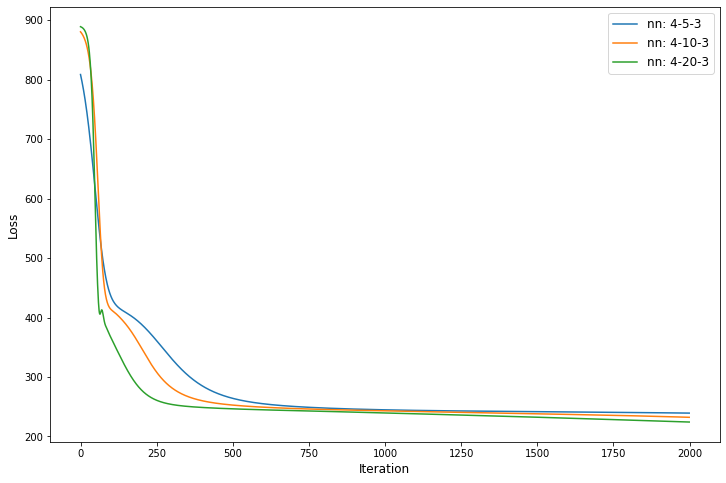

In [81]:
# Run the training for 3 different network architectures: (4-5-3) (4-10-3) (4-20-3)

# Plot the loss function over iterations
num_hidden_nodes = [5, 10, 20]
loss_plot = {5: [], 10: [], 20: []}
weights1 = {5: None, 10: None, 20: None}
biases1 = {5: None, 10: None, 20: None}
weights2 = {5: None, 10: None, 20: None}
biases2 = {5: None, 10: None, 20: None}

num_iters = 2000

plt.figure(figsize=(12,8))
for hidden_nodes in num_hidden_nodes:
    weights1[hidden_nodes], biases1[hidden_nodes], weights2[hidden_nodes], biases2[hidden_nodes] = create_train_model(hidden_nodes, num_iters)
    plt.plot(range(num_iters), loss_plot[hidden_nodes], label="nn: 4-%d-3" % hidden_nodes)
    
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)